In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

from IPython.display import display
from calendar import monthrange

In [2]:
%run 'backtest.py'
%run 'unconstrained_RB_portfolio_construction.py'

# 0. Some notations.

- $n$: positive integer, number of assets in our universe.
- $x$: $(n\times1)$ vector, dollar holding of each asset. We assume that $\text{GMV}=1$, i.e., $\sum_{i=1}^nx_i=1$.
- $b$: $(n\times1)$ vector, risk budget in percentage, i.e., $\sum_{i=1}^nb_i=1$.
- $\mu$: $(n\times1)$ vector, estimated return of each ticker.
- $\Sigma$: $(n\times n)$ matrix, estimated covariance matrix of tickers.

# 1. Import data.

In [3]:
close_raw = pd.read_excel('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/adj_closes.xlsx', index_col=0)
cap_raw = pd.read_excel('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/market_cap.xlsx', index_col=0)

In [4]:
print('head of raw close:')
display(close_raw.head(2))
print('tail of raw close:')
display(close_raw.tail(2))

head of raw close:


,FB,GOOG,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,...,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,PYPL,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,24.809999,442.282227,444.384399,24.853468,37.604179,58.466511,18.164701,32.040001,282.100006,66.952759,...,55.963364,19.760447,20.010237,46.240002,37.799999,27.309420,148.934998,62.600643,NaN,32.95216
2013-07-02,24.410000,439.507629,441.596588,25.015408,37.805790,57.853760,18.204906,31.637142,283.730011,67.335991,...,55.948971,19.619829,19.993795,46.029999,38.169998,27.300346,149.106339,62.618011,NaN,33.71442


tail of raw close:


,FB,GOOG,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,...,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,PYPL,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-28,193.0,1080.910034,1082.800049,32.561829,55.952717,138.780548,41.876125,367.320007,1893.630005,206.707718,...,263.888916,47.288704,53.977940,294.649994,151.729996,56.488377,134.703110,183.979553,114.459999,285.235352
2019-07-01,193.0,1097.949951,1100.000000,32.484093,55.492397,140.778183,42.302013,374.600006,1922.189941,209.003693,...,266.123474,47.466518,53.987801,300.970001,154.059998,57.519581,136.637207,186.070557,115.029999,297.611481


Transpose cap dataframe to make it day by asset.

In [5]:
cap_raw = pd.DataFrame(cap_raw.values.T, index=cap_raw.columns, columns=cap_raw.index)

In [6]:
cap_raw

HoldingsTicker,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,PYPL,AVGO
2014-06-30,217.51,359.98,183.52,202.63,148.49,139.56,26.41,149.45,109.45,99.57,...,85.84,179.77,132.78,36.75,33.31,187.14,183.48,65.90,44.74,16.05
2015-06-30,295.98,535.06,184.46,190.10,191.82,151.16,39.82,202.15,151.84,91.13,...,106.59,164.83,143.47,45.97,48.08,191.23,160.18,77.66,44.23,31.09
2016-06-30,336.81,556.91,266.00,227.62,158.45,158.23,39.18,337.65,172.63,105.64,...,96.78,173.45,154.56,49.59,54.89,166.82,145.70,96.27,48.57,64.67
2017-06-30,527.17,745.67,231.96,182.18,168.16,184.60,64.39,462.68,178.86,124.84,...,130.18,219.26,157.25,88.49,64.67,186.77,144.52,89.56,88.75,100.29
2018-06-29,376.72,726.73,197.80,208.33,157.00,153.15,173.07,831.57,227.57,123.17,...,206.36,214.19,198.32,122.47,88.50,190.73,128.39,114.07,99.09,96.92


Since cap data only starts from 2014-06-30, we

- use close data since 2015 as research data;
- use close data in 2014 as burn-in data (to calibrate covariance matrix which we will use in 2015).

We also need to
- drop the 'GOOG' column since it does not exist in close;
- drop the "PYPL' column since there are some np.nans in it.

In [7]:
close = close_raw['2015':].drop(labels=['GOOG', 'PYPL'], axis=1)
close_burn_in = close_raw['2014'].drop(labels=['GOOG', 'PYPL'], axis=1)

In [8]:
print('head of close data:')
display(close.head(2))
print('tail of burn-in close data:')
display(close_burn_in.tail(2))

head of close data:


,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,78.449997,529.549988,25.786736,37.423592,87.899757,26.164961,49.848572,308.519989,92.971001,81.714760,...,63.518238,82.850563,31.625349,23.754028,72.339996,59.240002,41.001865,130.591095,80.170738,90.019257
2015-01-05,77.190002,519.460022,25.543106,37.112793,86.615250,25.631353,47.311428,302.190002,91.020462,80.812263,...,62.116177,80.520157,31.268734,23.280836,71.980003,58.169998,40.426842,128.536270,78.817101,88.580238


tail of burn-in close data:


,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-30,79.220001,535.280029,25.946621,37.718464,88.790459,26.858433,49.032856,310.299988,93.726051,82.582207,...,63.405605,84.097977,31.973257,24.232641,73.080002,59.430000,41.936035,128.971390,81.388992,90.702797
2014-12-31,78.019997,530.659973,25.573561,37.280140,88.312309,26.466070,48.801430,310.350006,94.355286,82.100273,...,62.842369,83.314720,31.564465,23.771229,72.699997,59.310001,41.593811,129.285675,80.594864,90.468941


Reindex cap to make the indices for close price and cap same.

Also there is an extra space for each ticker name in cap_raw, we need to exclude it.

In [9]:
cap_raw.columns = [ticker[:-1] for ticker in cap_raw.columns]
cap = cap_raw.drop(columns=['PYPL']).reindex(index=close_raw.index, fill_value=np.nan).ffill()['2015':]

In [10]:
print('head of cap data:')
display(cap.head(2))
print('tail of cap data:')
display(cap.tail(2))

head of cap data:


,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,217.51,359.98,183.52,202.63,148.49,139.56,26.41,149.45,109.45,99.57,...,163.31,85.84,179.77,132.78,36.75,33.31,187.14,183.48,65.9,16.05
2015-01-05,217.51,359.98,183.52,202.63,148.49,139.56,26.41,149.45,109.45,99.57,...,163.31,85.84,179.77,132.78,36.75,33.31,187.14,183.48,65.9,16.05


tail of cap data:


,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-28,376.72,726.73,197.8,208.33,157.0,153.15,173.07,831.57,227.57,123.17,...,306.74,206.36,214.19,198.32,122.47,88.5,190.73,128.39,114.07,96.92
2019-07-01,376.72,726.73,197.8,208.33,157.0,153.15,173.07,831.57,227.57,123.17,...,306.74,206.36,214.19,198.32,122.47,88.5,190.73,128.39,114.07,96.92


Finally we make the indices and columns the same for cap and close.

In [11]:
close = pd.DataFrame(close.values, index=close.index, columns=close.columns)
cap = pd.DataFrame(cap.values, index=close.index, columns=close.columns)
close_burn_in = close_burn_in

In [12]:
close.head(2)

,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,78.449997,529.549988,25.786736,37.423592,87.899757,26.164961,49.848572,308.519989,92.971001,81.714760,...,63.518238,82.850563,31.625349,23.754028,72.339996,59.240002,41.001865,130.591095,80.170738,90.019257
2015-01-05,77.190002,519.460022,25.543106,37.112793,86.615250,25.631353,47.311428,302.190002,91.020462,80.812263,...,62.116177,80.520157,31.268734,23.280836,71.980003,58.169998,40.426842,128.536270,78.817101,88.580238


In [13]:
cap.head(2)

,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,217.51,359.98,183.52,202.63,148.49,139.56,26.41,149.45,109.45,99.57,...,163.31,85.84,179.77,132.78,36.75,33.31,187.14,183.48,65.9,16.05
2015-01-05,217.51,359.98,183.52,202.63,148.49,139.56,26.41,149.45,109.45,99.57,...,163.31,85.84,179.77,132.78,36.75,33.31,187.14,183.48,65.9,16.05


In [14]:
close_burn_in.head(2)

,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,54.709999,557.117126,25.254278,37.378609,70.613052,23.172962,51.831429,397.970001,72.167175,80.955902,...,51.396935,80.195457,21.742401,18.357819,59.290001,54.860001,34.576424,145.959686,71.374649,46.618820
2014-01-03,54.560001,553.053040,25.145884,36.936169,70.464928,23.001812,51.871429,396.440002,72.052780,81.065048,...,51.431812,79.875313,21.733967,18.341125,59.160000,55.119999,34.484753,146.832977,71.612175,46.795918


After all these modifications, we store our data.

In [15]:
cap.to_csv('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/cap_clean.csv')
close.to_csv('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/close_clean.csv')
close_burn_in.to_csv('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/close_burn_in_clean.csv')

# 2. Initial analysis.

Calculate daily return.

In [16]:
ret = close.diff()/close.shift(1)

In [17]:
ret.head(3)

,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.016061,-0.019054,-0.009448,-0.008305,-0.014613,-0.020394,-0.050897,-0.020517,-0.020980,-0.011044,...,-0.022073,-0.028128,-0.011276,-0.019921,-0.004976,-0.018062,-0.014024,-0.015735,-0.016884,-0.015986
2015-01-06,-0.013473,-0.024679,0.001490,0.010093,-0.005304,-0.013045,-0.017121,-0.022833,-0.003062,0.001844,...,-0.006444,-0.002162,-0.018637,-0.000370,-0.020145,-0.016675,-0.010323,-0.021566,-0.007213,-0.022743


We also need to calculate return during burn-in period.

In [18]:
ret_burn_in = close_burn_in.diff()/close_burn_in.shift(1)

Store the start and end year of our strategy.

In [19]:
start_year = ret.index[0].year
end_year = ret.index[-1].year

## 2.1. Index (cap weighted) portfolio.

<span class="burk">Note: now all the daily data (return, close price and cap) are known after close.</span>

<span class="burk">In order to make the data known before open to run our backtest without lookahead bias, we need to shift the weight matrix by 1 after constructing it.</span>

Construct index portfolio.

In [20]:
index_weight = cap/np.tile(np.sum(cap, axis=1), reps=(cap.shape[1], 1)).T

In [21]:
index_weight.head(2)

,FB,GOOGL,T,VZ,DIS,CMCSA,NFLX,AMZN,HD,MCD,...,V,MA,INTC,CSCO,ADBE,CRM,ORCL,IBM,ACN,AVGO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.02735,0.045264,0.023076,0.025479,0.018671,0.017548,0.003321,0.018792,0.013762,0.01252,...,0.020535,0.010793,0.022604,0.016696,0.004621,0.004188,0.023531,0.023071,0.008286,0.002018
2015-01-05,0.02735,0.045264,0.023076,0.025479,0.018671,0.017548,0.003321,0.018792,0.013762,0.01252,...,0.020535,0.010793,0.022604,0.016696,0.004621,0.004188,0.023531,0.023071,0.008286,0.002018


/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


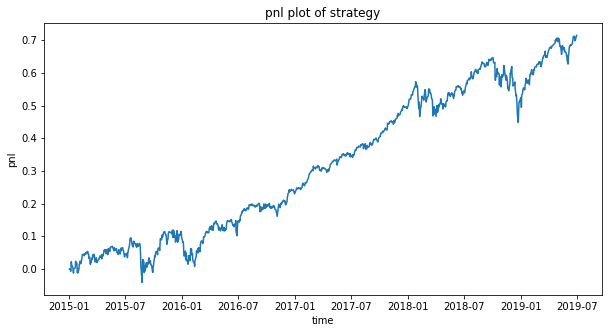

,turnover,Sharpe ratio,maximum drawdown,annual return
2015,0.000717,0.605612,-0.136774,0.096450
2016,0.000685,1.039586,-0.074305,0.148270
2017,0.000632,3.775969,-0.021015,0.252221
2018,0.000814,0.160546,-0.198987,0.020652
2019,0.000000,2.016617,-0.079996,0.190013
average,0.000569,1.519666,-0.198987,0.141521


In [22]:
# we can ignore the warning of plt package.
index_pnl, index_backtest_res = display_backtest(index_weight.shift(1), ret)

- This is just how the market behaves from 2014 till now.

## 2.2. Equal weighted portfolio.

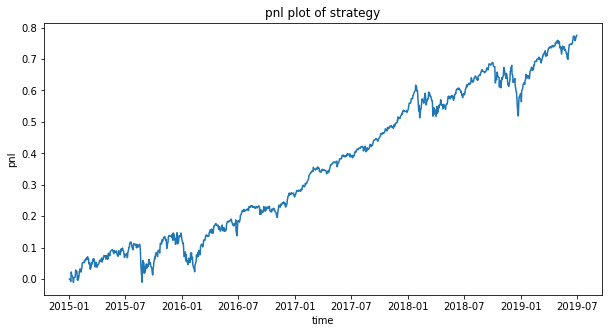

,turnover,Sharpe ratio,maximum drawdown,annual return
2015,0.0,0.812055,-0.128263,0.129487
2016,0.0,1.006261,-0.090759,0.148507
2017,0.0,4.105214,-0.021811,0.260487
2018,0.0,0.340216,-0.169977,0.049356
2019,0.0,2.159213,-0.060654,0.185474
average,0.0,1.684592,-0.169977,0.154662


In [23]:
equal_weight = pd.DataFrame(1/index_weight.shape[1], index=index_weight.index,\
                            columns=index_weight.columns)
# we can ignore the warning of plt package.
equal_weight_pnl, equal_weight_backtest_res = display_backtest(equal_weight.shift(1), ret)

- Compared with cap weighted portfilio, we have larger Sharpe, higher return and lower drawdown.
- This is probably a result of cap size effect.

# 3. Correlation profile.

Before we step into our topic of risk budgeting portfolio problem, we need to look at the general correlation profile in our universe first.

In [24]:
def correlation_heat_plot(ret_frame, year):
    _start_year = ret_frame.index[0].year
    _end_year = ret_frame.index[-1].year
    
    if (year<_start_year) or (year>_end_year):
        raise ValueError('year number is out of range.')
    else:
        plt.figure(figsize=(8, 7))
        sns.heatmap(ret_frame[str(year)].corr())

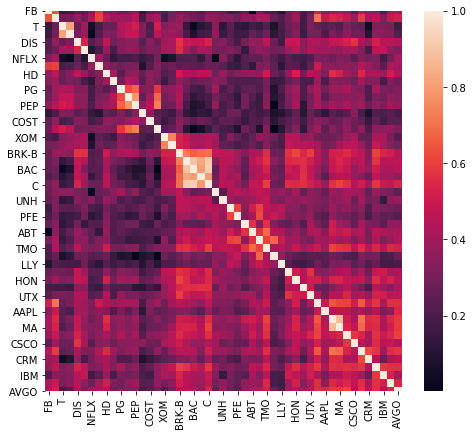

In [25]:
correlation_heat_plot(ret, 2016)

- In general, there is no particular concern (large area of high correlation) on this plot.

# 4. A special case of unconstrained risk budgeting portfolio: ERC (Equal Risk Contribution) portfolio.

Note: we will assume risk free rate $r=0$ throughout this part.

In [26]:
r = 0

The risk measure is defined as

$$
\begin{aligned}
\mathcal{R}(x)&=-x^\top(\mu-r)+c\cdot\sqrt{x^\top\Sigma x}\\
&=-x^\top\mu+c\cdot\sqrt{x^\top\Sigma x}
\end{aligned}
$$

since $r=0$.

The optimization problem is formulated as

$$
x^\star(\kappa)=\text{argmin}\ \mathcal{R}(x)\\
\text{s.t.}\ 
\begin{cases}
\sum_{i=1}^nb_i\log x_i\geq \kappa\\
\mathcal{1}^\top x=1\\
x\geq0
\end{cases}
$$

where $\kappa$ is an arbitrary constant and we use

$$
x_{\text{RB}}=\frac{x^\star(\kappa)}{\mathcal{1}^\top x^\star(\kappa)}
$$

to compute our RB portfolio.

The problem above is equivalent to

$$
x^\star(\lambda)=\text{argmin}\ \mathcal{R}(x)-\lambda\sum_{i=1}^nb_i\log x_i\\
\text{s.t.}\ x\geq0
$$

and

$$
x_{\text{RB}}=\frac{x^\star(\lambda)}{\mathcal{1}^\top x^\star(\lambda)}
$$

# 4.1. Case 1: Annual rebalancing.

Construct the covariance matrix and expected return vector of our universe for every year.

We assume that they are known at the end of the time indicated by the key value of the dictionary.

In [27]:
Sig_dict_1y, mu_dict_1y = {}, {}

for year in range(start_year, end_year+1):
    Sig_dict_1y[str(year)] = ret[str(year)].cov().values
    mu_dict_1y[str(year)] = np.nanmean(ret[str(year)], axis=0)

# add burn-in period into the dictionary.
Sig_dict_1y[str(start_year-1)] = ret_burn_in.cov().values
mu_dict_1y[str(start_year-1)] = np.nanmean(ret_burn_in, axis=0)

Parameters:

- $c=1$
- $b_i=\frac1n,\forall i$.
- $\lambda=1$.

In [28]:
n = len(ret.columns)
c = 1
b = np.array([1/n]*n).reshape(n, 1)
lambd = 1

In [29]:
x_lst = []

for year in range(start_year, end_year+1):
    mu = mu_dict_1y[str(year-1)]
    Sig = Sig_dict_1y[str(year-1)]
    opt_res = RB_unconstrianed(r, mu, c, Sig, b, lambd=lambd,\
                               opt_algo='RCD', max_iter=20000, prec=1e-8)
    if opt_res['x_opt'] != 'time out':
        x_lst.append(opt_res['x_opt'])
    else:
        raise ValueError('x_opt is invalid because time is out.')

/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Transform our optimization result into a valid weight matrix.

In [30]:
ERC_weight_yearly = np.array(x_lst).reshape((5, 49))
ERC_weight_yearly = ERC_weight_yearly/np.tile(np.sum(ERC_weight_yearly, axis=1), reps=(ERC_weight_yearly.shape[1], 1)).T

In [31]:
yearly_first_day = [ret[str(year)].index[0] for year in range(start_year, end_year+1)]
ERC_yearly_weight = pd.DataFrame(ERC_weight_yearly, index=yearly_first_day, columns=ret.columns)
ERC_yearly_weight = ERC_yearly_weight.reindex(index=ret.index, fill_value=np.nan).ffill()

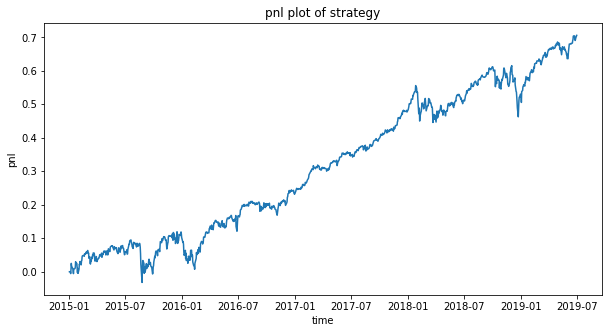

,turnover,Sharpe ratio,maximum drawdown,annual return
2015,0.000000,0.666643,-0.127019,0.102240
2016,0.000746,1.031200,-0.082298,0.143795
2017,0.000744,4.055385,-0.018310,0.237315
2018,0.001030,0.329023,-0.152853,0.045988
2019,0.001797,2.224984,-0.049908,0.176676
average,0.000863,1.661447,-0.152853,0.141203


In [32]:
# we can ignore the warning of plt package.
ERC_yearly_pnl, ERC_yearly_backtest_res = display_backtest(ERC_yearly_weight.shift(1), ret)

Compare performance of cap weighted portfolio, equal weighted portfolio and ERC portfolio.

In [33]:
def compare_performance(backtest_res_lst, name_lst, x_axis):
    if len(backtest_res_lst) != len(name_lst):
        raise ValueError('lengths of backtest result list and name list are not the same.')
    
    plt.figure(figsize=(15, 15))
    
    plt.subplot(2, 2, 1)
    for i in range(len(backtest_res_lst)):
        plt.plot(x_axis, backtest_res_lst[i]['turnover'][:-1], label=name_lst[i], marker='o')
    plt.xlabel('year')
    plt.ylabel('turnover')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    for i in range(len(backtest_res_lst)):
        plt.plot(x_axis, backtest_res_lst[i]['Sharpe ratio'][:-1], label=name_lst[i], marker='o')
    plt.xlabel('year')
    plt.ylabel('Sharpe ratio')
    plt.legend()

    plt.subplot(2, 2, 3)
    for i in range(len(backtest_res_lst)):
        plt.plot(x_axis, backtest_res_lst[i]['maximum drawdown'][:-1], label=name_lst[i], marker='o')
    plt.xlabel('year')
    plt.ylabel('maximum drawdown')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    for i in range(len(backtest_res_lst)):
        plt.plot(x_axis, backtest_res_lst[i]['annual return'][:-1], label=name_lst[i], marker='o')
    plt.xlabel('year')
    plt.ylabel('annual return')
    plt.legend()
    
    plt.show()

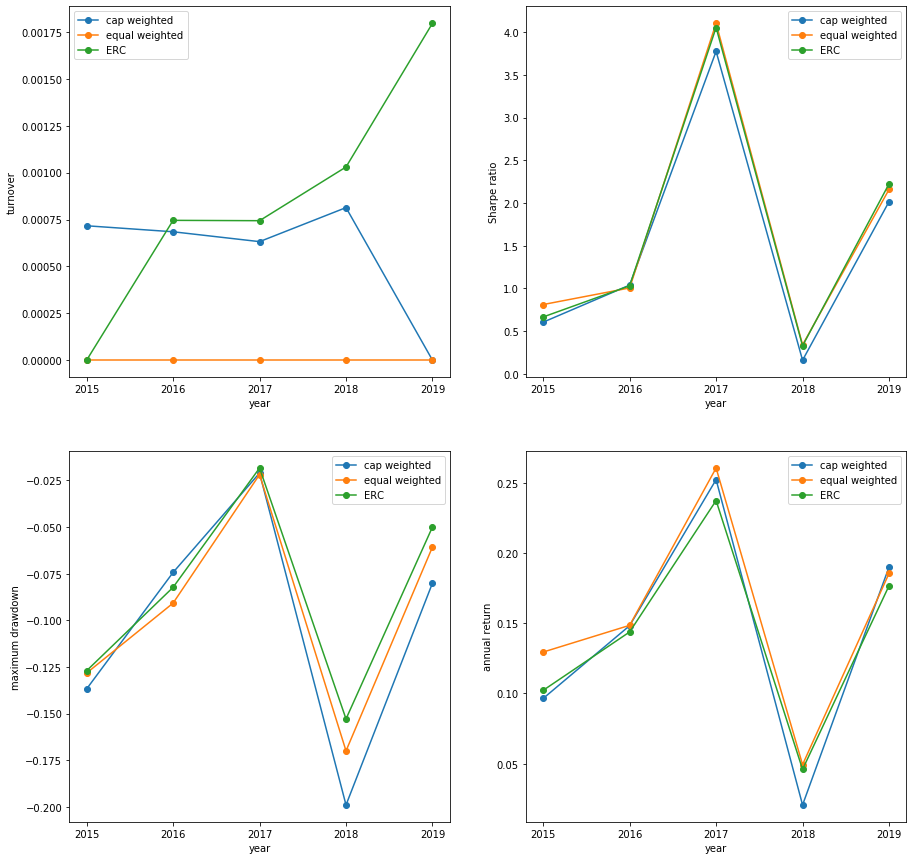

In [34]:
compare_performance([index_backtest_res, equal_weight_backtest_res, ERC_yearly_backtest_res],\
                    ['cap weighted', 'equal weighted', 'ERC'], [str(year) for year in range(start_year, end_year+1)])

- Compared with cap weighted portfolio, we increased Sharpe and decreased drawdown, which are reasonable effects of ERC portfolio.
- The performance of ERC portfolio is more like equal-weighted portfolio than cap-weighted portfolio, which is probably because there are not many significant correlation relationships between tickers.

Now change the value of $c$. The larger $c$ is, we are more focusing on the volatility rather than the expected return.

Since we run a long-only strategy, the most important factor which will affect the performance is apparently the market beta. Therefore, we will see the difference of performance between our strategy with some specific $c$ and the index portfolio.

In [35]:
c_lst = np.exp(np.arange(-0.5, 1.5, 0.1))
backtest_res_c_lst = []

for c_val in c_lst:
    x_lst = []
    
    for year in range(start_year, end_year+1):
        mu = mu_dict_1y[str(year-1)]
        Sig = Sig_dict_1y[str(year-1)]
        opt_res = RB_unconstrianed(r, mu, c_val, Sig, b, lambd=lambd,\
                                   opt_algo='RCD', max_iter=20000, prec=1e-8)
        if opt_res['x_opt'] != 'time out':
            x_lst.append(opt_res['x_opt'])
        else:
            raise ValueError('x_opt is invalid because time is out.')
    
    ERC_weight_yearly_c = np.array(x_lst).reshape((5, 49))
    ERC_weight_yearly_c = ERC_weight_yearly_c/np.tile(np.sum(ERC_weight_yearly_c, axis=1), reps=(ERC_weight_yearly_c.shape[1], 1)).T
    ERC_yearly_weight_c = pd.DataFrame(ERC_weight_yearly_c, index=yearly_first_day, columns=ret.columns)
    ERC_yearly_weight_c = ERC_yearly_weight_c.reindex(index=ret.index, fill_value=np.nan).ffill()
    ERC_yearly_pnl_c, ERC_yearly_backtest_res_c = display_backtest(ERC_yearly_weight_c.shift(1), ret, show_plot=False)
    backtest_res_c_lst.append(ERC_yearly_backtest_res_c-index_backtest_res)

/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


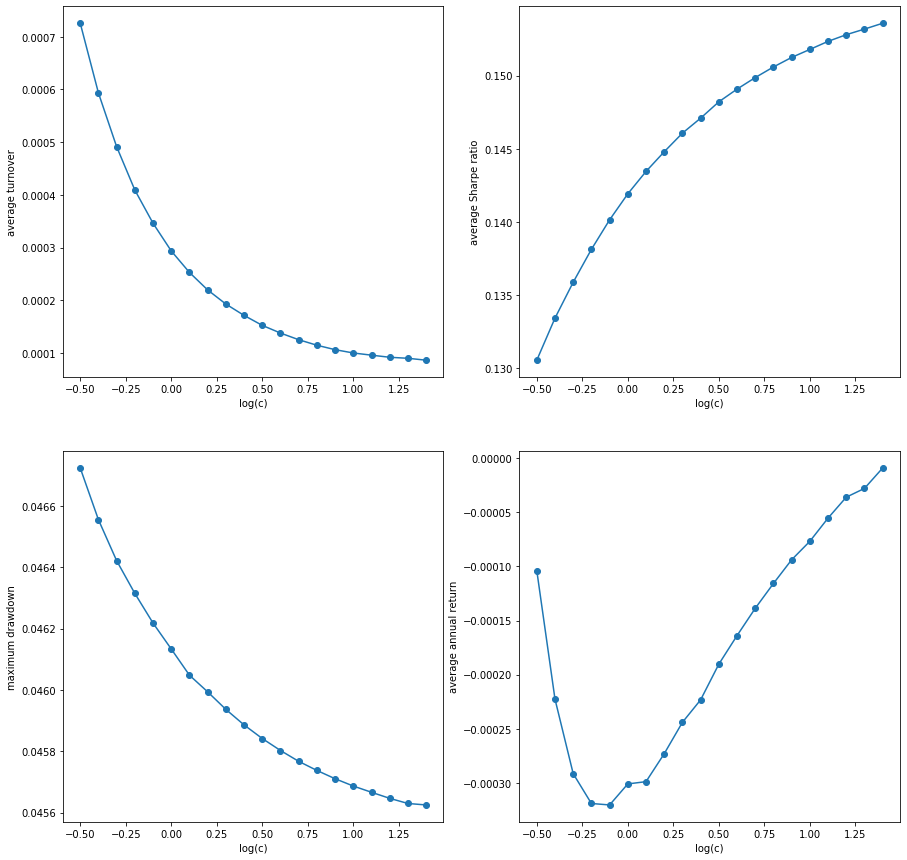

In [36]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(np.log(c_lst), [res['turnover'][-1] for res in backtest_res_c_lst], marker='o')
plt.xlabel('log(c)')
plt.ylabel('average turnover')

plt.subplot(2, 2, 2)
plt.plot(np.log(c_lst), [res['Sharpe ratio'][-1] for res in backtest_res_c_lst], marker='o')
plt.xlabel('log(c)')
plt.ylabel('average Sharpe ratio')

plt.subplot(2, 2, 3)
plt.plot(np.log(c_lst), [res['maximum drawdown'][-1] for res in backtest_res_c_lst], marker='o')
plt.xlabel('log(c)')
plt.ylabel('maximum drawdown')

plt.subplot(2, 2, 4)
plt.plot(np.log(c_lst), [res['annual return'][-1] for res in backtest_res_c_lst], marker='o')
plt.xlabel('log(c)')
plt.ylabel('average annual return')

plt.show()

As $c$ increases,
- turnover deceases, which means that the covariance matrix of last year indeed has predicting power on the covariance profile of this year.
- Sharpe increases, which is a natural payoff for us when we are more careful about the daily volatility.
- drawdown is larger, which is interesting. This tells us that the more careful we are about the volatilty moves in the "normal region", the greater loss we will suffer when there is a tail event (i.e., volatilitiy spike).

## 4.2. Case 2: Monthly rebalancing.

Construct the covariance matrix and expected return vector of our universe for each month.

In [37]:
# since now we calibrate for each month,
# we need the full history of return.
ret_full = pd.concat([ret_burn_in, ret], axis=0)

In [38]:
Sig_dict_1m, mu_dict_1m = {}, {}

for year in range(start_year, end_year+1):
    for month in range(1, 13):
        
        month_end_date = monthrange(year, month)[1]  # last day of this month
        # calculate our calibration start and end date in string.
        range_end_date = datetime.date(year, month, month_end_date).strftime('%Y%m%d')
        range_start_date = (datetime.date(year, month, month_end_date)+timedelta(days=-365+1)).strftime('%Y%m%d')
        
        # calibrate covariance matrix and expected return vector.
        Sig_dict_1m[str(year)+str(format(month, '02d'))] = ret_full[range_start_date:range_end_date].cov().values
        mu_dict_1m[str(year)+str(format(month, '02d'))] = np.nanmean(ret_full[range_start_date:range_end_date], axis=0)
        
# add burn-in period into the dictionary.
Sig_dict_1m[str(start_year-1)+'12'] = ret_burn_in.cov().values
mu_dict_1m[str(start_year-1)+'12'] = np.nanmean(ret_burn_in, axis=0)

Set parameters as usual.

In [39]:
n = len(ret.columns)
c = 1
b = np.array([1/n]*n).reshape(n, 1)
lambd = 1

In [40]:
x_lst = []

for year in range(start_year, end_year+1):
    # if this is not the last year,
    # we have valid data for each month.
    if year != end_year:
        for month in range(1, 13):
            # the key we will use to get Sigma and mu from the dictionaries.
            key = (date(year, month, 1)+relativedelta(months=-1)).strftime('%Y%m')
            mu = mu_dict_1m[key]
            Sig = Sig_dict_1m[key]
            # run optimization algo.
            opt_res = RB_unconstrianed(r, mu, c, Sig, b, lambd=lambd,\
                                       opt_algo='RCD', max_iter=20000, prec=1e-8)
            if opt_res['x_opt'] != 'time out':
                x_lst.append(opt_res['x_opt'])
            else:
                raise ValueError('x_opt is invalid because time is out.')
    
    # for the last year, we only have data for the first 6 monyhs
    else:
        for month in range(1, 7):
            key = (date(year, month, 1)+relativedelta(months=-1)).strftime('%Y%m')
            mu = mu_dict_1m[key]
            Sig = Sig_dict_1m[key]
            opt_res = RB_unconstrianed(r, mu, c, Sig, b, lambd=lambd,\
                                       opt_algo='RCD', max_iter=20000, prec=1e-8)
            if opt_res['x_opt'] != 'time out':
                x_lst.append(opt_res['x_opt'])
            else:
                raise ValueError('x_opt is invalid because time is out.')

/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app
/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [41]:
ERC_weight_monthly = np.array(x_lst).reshape((len(x_lst), 49))
ERC_weight_monthly = ERC_weight_monthly/np.tile(np.sum(ERC_weight_monthly, axis=1), reps=(ERC_weight_monthly.shape[1], 1)).T

In [42]:
monthly_first_day = [ret[str(year)+str(format(month, '02d'))+'01':].index[0] for year in range(start_year, end_year) for month in range(1, 13)]
monthly_first_day += [ret[str(end_year)+str(format(month, '02d'))+'01':].index[0] for month in range(1, 7)]
ERC_monthly_weight = pd.DataFrame(ERC_weight_monthly, index=monthly_first_day, columns=ret.columns)
ERC_monthly_weight = ERC_monthly_weight.reindex(index=ret.index, fill_value=np.nan).ffill()

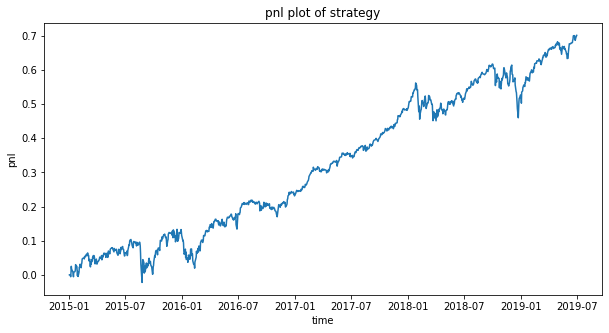

,turnover,Sharpe ratio,maximum drawdown,annual return
2015,0.001782,0.744576,-0.125871,0.115700
2016,0.001573,0.935246,-0.081568,0.131908
2017,0.003313,4.104761,-0.018086,0.243225
2018,0.003082,0.272329,-0.157378,0.037086
2019,0.001904,2.250920,-0.049254,0.175425
average,0.002331,1.661566,-0.157378,0.140669


In [43]:
# we can ignore the warning of plt package.
ERC_monthly_pnl, ERC_monthly_backtest_res = display_backtest(ERC_monthly_weight.shift(1), ret)

- Compared with annua rebalancing ERC portfolio, there is almost no difference in performance.
- This is probably because that the correlation matrix $\Sigma$ and expected return vector $\mu$ are slow-varying.